In [1]:
!pip install lime

In [2]:
# Importing necessary packages

# for segmentation part
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Activation, add

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError

from tensorflow.keras import backend as K

sns.set_theme(style='darkgrid', palette='pastel')

#from tensorflow.keras.models import load_model
import keras

#Occlusion
from PIL import Image
import copy
import math
from keras.models import load_model


# for classification part
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm
from torchvision.transforms import functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
from numpy.random import default_rng
from PIL import Image
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

import zipfile
from google.colab import drive

In [3]:
# Set seed for reproducibility
fixed_seed = 42
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)
torch.cuda.manual_seed_all(fixed_seed)

# Ensure deterministic behavior for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1 Classification: MobileVNet3

In [4]:
# You have to set it to your drive link later on, all that paths.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Unzip the downloaded file
with zipfile.ZipFile("/content/drive/MyDrive/XAI/SkinCancer.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_folder")

# List contents
import os
os.listdir("extracted_folder")

['GroundTruth.csv', 'masks', 'images']

In [6]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

# TODO: visszajavítani a path-t
#skin_cancer_df = pd.read_csv('/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/GroundTruth.csv')
skin_cancer_df = pd.read_csv('/content/extracted_folder/GroundTruth.csv')
skin_cancer_df.drop(columns=['BKL'], inplace=True)
skin_cancer_df = skin_cancer_df[columns_rearranged]

multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

filenames_list, multiclass_categories_list = [], []

# base_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images"

# TODO: visszajavítani a path-t
# base_paths = [
#     ("/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images", skin_cancer_df),
# ]

base_paths = [
    ("/content/extracted_folder/images", skin_cancer_df),
]

"""
base_paths = [
    ("images", skin_cancer_df),
]
"""

Using device: cuda


'\nbase_paths = [\n    ("images", skin_cancer_df),\n]\n'

In [7]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")

Multi-class weights: {0: 0.6416581240389544, 1: 4.499101527403414, 2: 9.742217898832685, 3: 15.313455657492355, 4: 43.54347826086956, 5: 35.264084507042256}


<ipython-input-8-a76bd2b1a029>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)


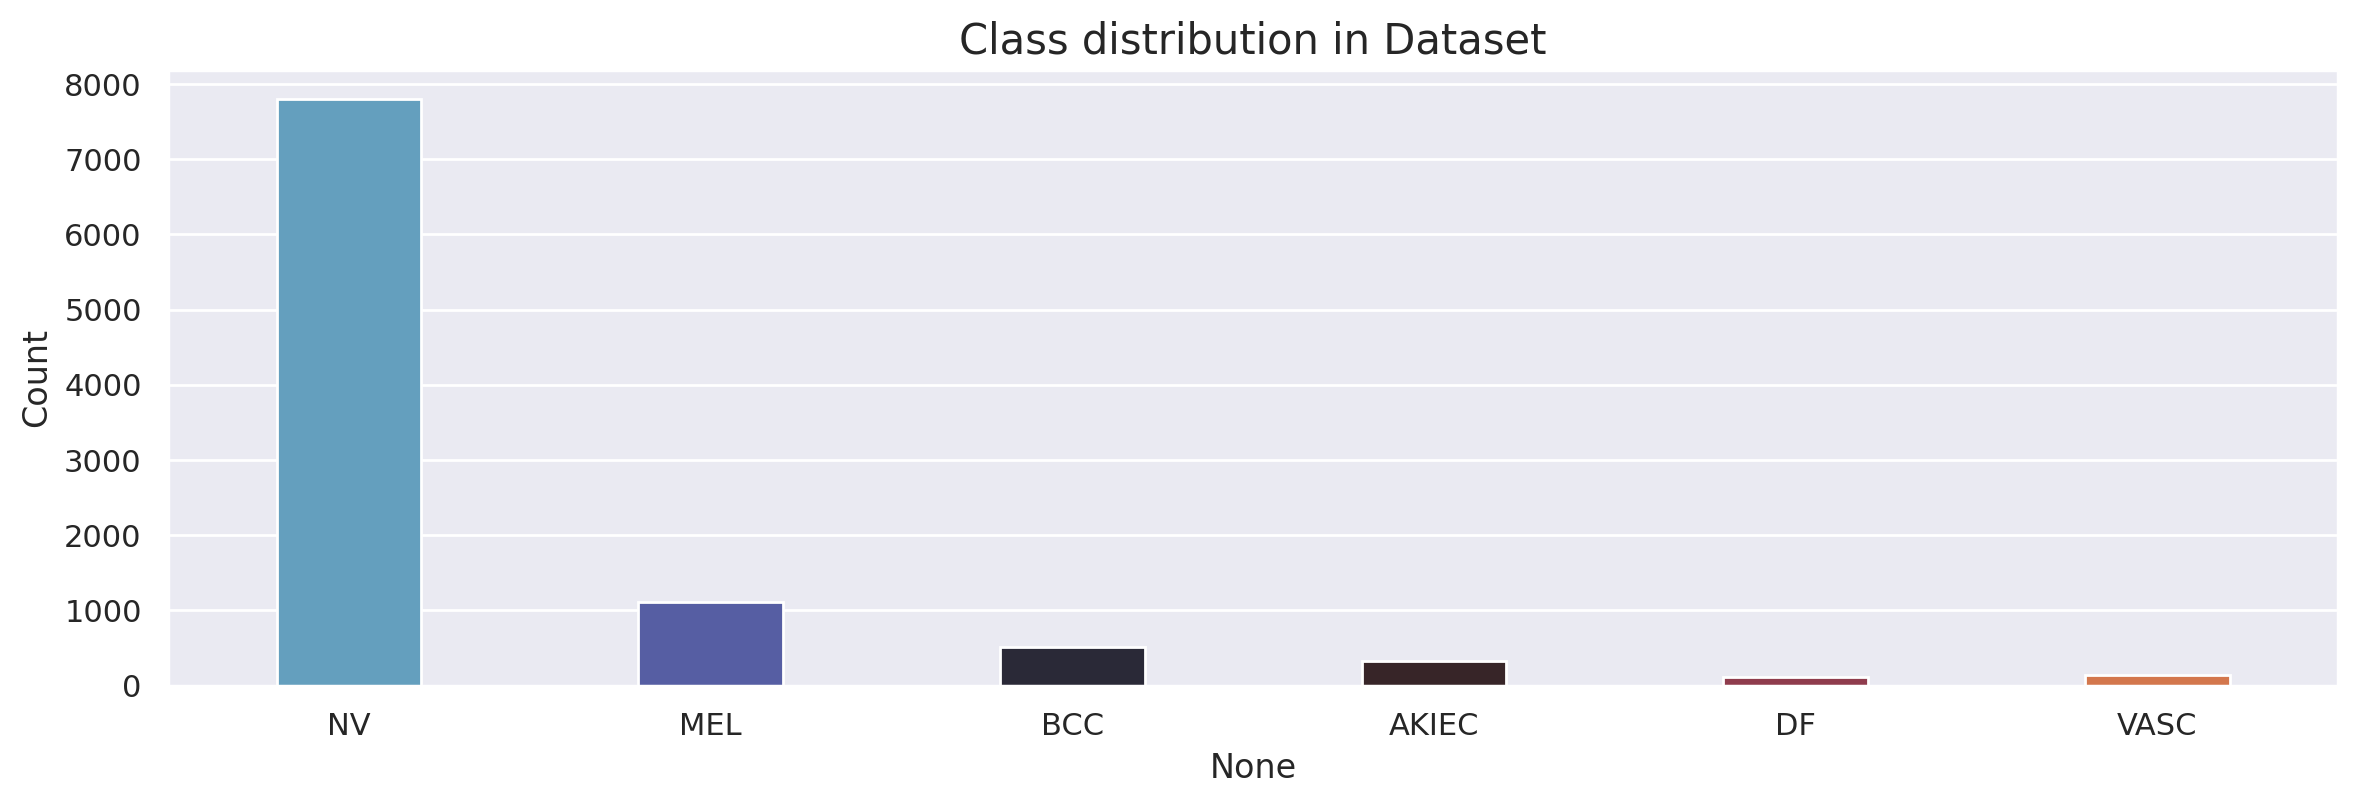

In [8]:
# Visualization
label, count = np.unique(multiclass_df.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

As we can see, the original dataset is heavily imbalanced towards the class “NV”, considerably less amount of samples are present in the dataset from other classes, especially from classes “DF” and “VASC”. This plot can give useful information for model builders & developers when constructing or improving a machine learning model on this skin cancer dataset.

## 1.1 DataLoading for classification

In [9]:
# TODO: Set the path to yours
#dataset_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/"
dataset_path = "/content/extracted_folder"
# dataset_path = "images"
valid_images = []

for img_file in os.listdir(dataset_path):
    try:
        img_path = os.path.join(dataset_path, img_file)
        with Image.open(img_path) as img:
            img.verify()  # Verify that the file is intact
        valid_images.append(img_file)
    except Exception as e:
        print(f"Skipping corrupted image: {img_file}, Error: {e}")

Skipping corrupted image: GroundTruth.csv, Error: cannot identify image file '/content/extracted_folder/GroundTruth.csv'
Skipping corrupted image: masks, Error: [Errno 21] Is a directory: '/content/extracted_folder/masks'
Skipping corrupted image: images, Error: [Errno 21] Is a directory: '/content/extracted_folder/images'


In [10]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass_df, test_size=0.2, stratify=multiclass_df['category'], random_state=fixed_seed)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=fixed_seed)

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

class DeterministicTransform:
    def __init__(self, seed):
        self.seed = seed

    def __call__(self, img):
        random.seed(self.seed)  # Set the random seed for consistency
        np.random.seed(self.seed)

        # Define deterministic augmentations
        if random.random() < 0.5:  # Horizontal Flip
            img = transforms.functional.hflip(img)
        if random.random() < 0.5:  # Vertical Flip
            img = transforms.functional.vflip(img)
        angle = random.uniform(-20, 20)  # Rotation
        img = transforms.functional.rotate(img, angle)

        return img

image_size = (224, 224)
batch_size = 32

# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize(image_size),
    DeterministicTransform(seed=fixed_seed),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SkinCancerDataset(multiclass_train_df, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 1.2 Classification: MobileNetV3

Source for the model implementation: https://www.kaggle.com/code/dariusfoodeei/multiclass-skincancer-torch

In [11]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

model_class = MobileNetV3(num_classes=len(multiclass_categories))
model_class = model_class.to(device)

[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]

model_class = MobileNetV3(num_classes=len(multiclass_categories))
model_class = model_class.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.Adam(model_class.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

num_epochs = 20
early_stopping_patience = 6
best_val_loss = float('inf')
epochs_no_improve = 0

# This might result in partially loaded images, so proceed with caution !!!!
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break

# This is commented out to not to train the model again
# train_model(model_class, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Load best classification model**

In [12]:
# Load the best model (PyTorch format)

model_class = MobileNetV3(num_classes=len(multiclass_categories))
model_class.load_state_dict(torch.load('/content/drive/MyDrive/XAI/best_model_classification.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model_class.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_class.to(device)

<ipython-input-12-7b8ad7cc3b66>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_class.load_state_dict(torch.load('/content/drive/MyDrive/XAI/best_model_classification

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

In [13]:
# Test the model
model_class.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')

# Export the model
#torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model_class(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')

Testing: 100%|██████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.77it/s]

Test Loss: 1.3591
Test Accuracy: 76.05%
Precision: 76.05%


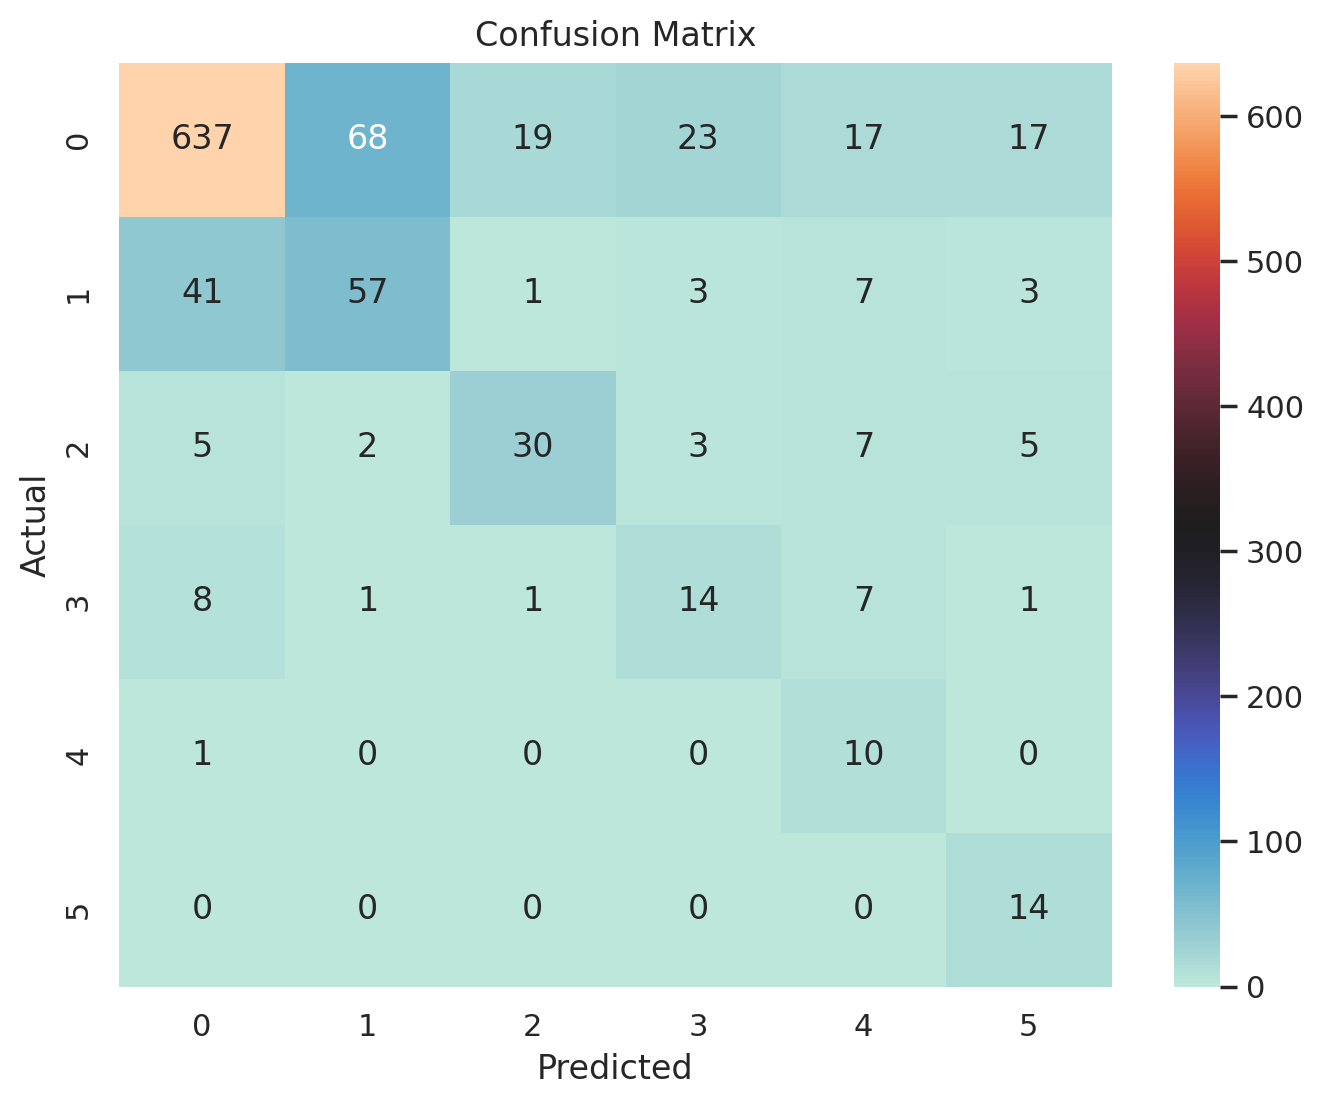

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

This plot shows the confusion matrix on the test set produced by the best trained classification model. The confusion matrix also underlines our previous findings about the dataset, namely that it is heavily imbalanced and most instances belong to class “NV” (0). As we can see, the model performs well on the majority class „NV” (0) (637 correct predictions), but seems to struggle for class „MEL” (1) (41 correct predictions versus 68 misclassifications into class 0). It also underperforms for class „DF” (4) and „VASC”(5) likely due to the insufficient representation of these classes in the dataset. This confusion matrix can be insightful for model builders & developers when evaluating and improving their trained machine learning model.

# 2 Segmentation: Fuzzy U-net

Source for this model: https://www.kaggle.com/code/iakhtar0/2-skin-cancer-images-segmentation-fuzzy-unet

## 2.1 Segmentation plots

In [15]:
# images and masks folder paths
image_dir = '/content/extracted_folder/images'
mask_dir = '/content/extracted_folder/masks'

# list of images and masks from the directory
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

# generating lis of image names (without extension) & masks names (without 'segmentation' suffix & extension)
image_names = [os.path.splitext(f)[0] for f in image_files]
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]

# checking if all the images have corresponding masks or not
missing_masks = [img for img in image_names if img not in mask_names]

if len(missing_masks) == 0:
    print('All images have corresponding masks...')
else:
    print('There are some images that dont have masks...')

All images have corresponding masks...


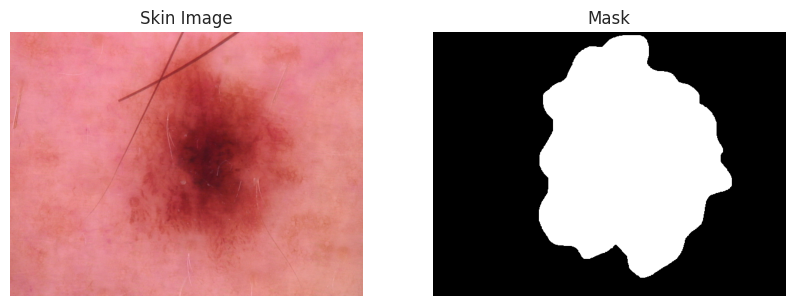

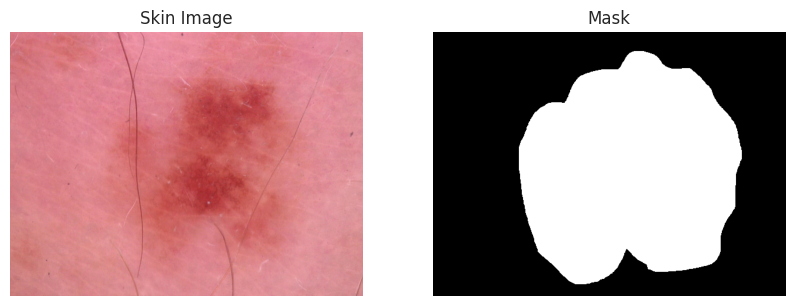

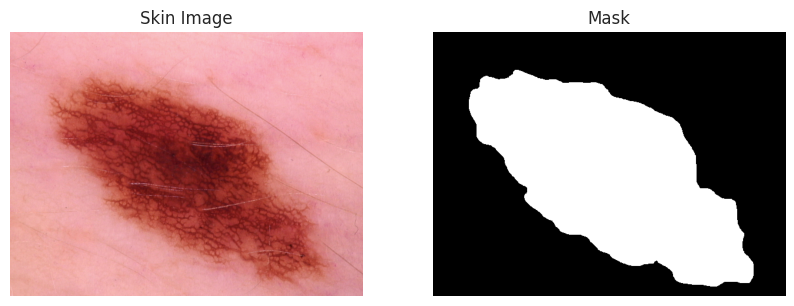

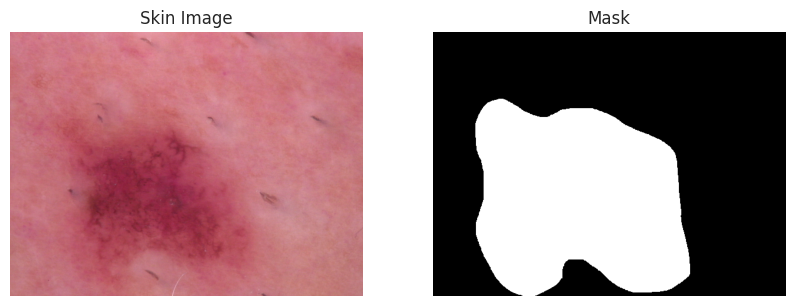

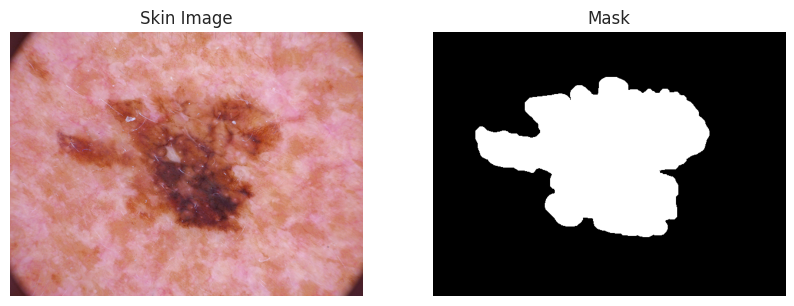

In [16]:
# function to display image & mask
def display_function(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # side by side display
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(image)
    axis[0].set_title('Skin Image')
    axis[0].axis('off')

    axis[1].imshow(mask, cmap='gray')
    axis[1].set_title('Mask')
    axis[1].axis('off')

    plt.show()


# Displaying 5 images & masks
for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    display_function(image_path, mask_path)

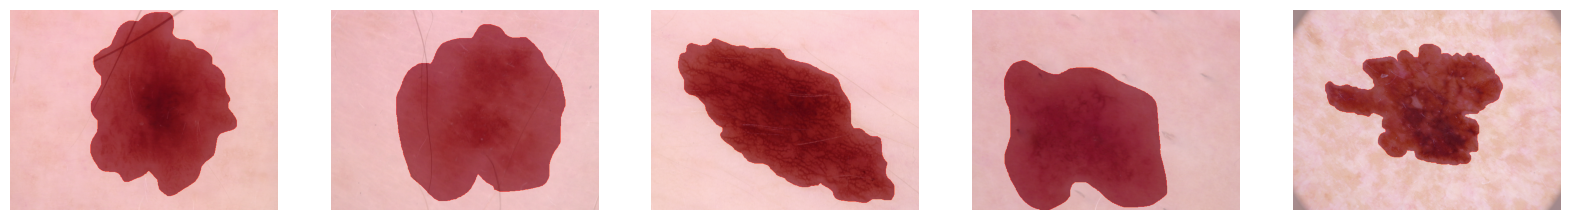

In [17]:
# function to display masked images
def display_masked_images(image_path, mask_path):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # converting image & mask to numpy array
    image_np = np.array(image)
    mask_np = np.array(mask)

    return image_np, mask_np

# displaying 5 masked images
fig, axis = plt.subplots(1, 5, figsize=(20,5))

for i in range(5):
    image_path = os.path.join(image_dir, image_files[i])

    mask_name = os.path.splitext(image_files[i])[0] + '_segmentation.png'
    mask_path = os.path.join(mask_dir, mask_name)

    image_np, mask_np = display_masked_images(image_path, mask_path)

    # display masked images
    axis[i].imshow(image_np)
    axis[i].imshow(mask_np, cmap='Reds', alpha=0.5) # alpha - to make it semi transparent
    axis[i].axis('off')

plt.show()

## 2.2 DataLoading for segmentation

In [18]:
# setting the default values
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 1000

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMG_DIR = '/content/extracted_folder/images'
MASK_DIR = '/content/extracted_folder/masks'

# function to get image path and masks
def image_mask_paths(image_dir, mask_dir):
    images_path = sorted(gb.glob(os.path.join(image_dir, '*.jpg')))
    masks_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))

    images_path = np.array(images_path)
    masks_path = np.array(masks_path)

    return images_path, masks_path

images_path, masks_path = image_mask_paths(IMG_DIR, MASK_DIR)

print("Number of images:", len(images_path))
print("Number of masks:", len(masks_path))

Number of images: 10015
Number of masks: 10015


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(images_path, masks_path, train_size=0.8, random_state=fixed_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=fixed_seed)

print(f'Training Samples: {len(X_train)}')
print(f'Validation Samples: {len(X_val)}')
print(f'Testing Samples: {len(X_test)}')

# function to loading & preprocessing data

def mapping_function(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)/255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

# creating training set
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# creating validation set
validation_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_set = validation_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
validation_set = validation_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# creating testing set
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(mapping_function, num_parallel_calls=AUTOTUNE)
test_set = test_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Training Samples: 8012
Validation Samples: 1001
Testing Samples: 1002


## 2.3 Segmentation: Fuzzy U-net implementation

In [20]:
def fuzzy_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    skip_connections = []

    # Encoder
    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        skip_connections.append(x)
        x = MaxPooling2D(2, padding="same")(x)

    # Bottleneck with fuzzy membership calculations
    x = Conv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder with fuzzy skip connections
    for filters in [512, 256, 128, 64]:
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)

        # Fuzzy attention for skip connections
        skip_connection = skip_connections.pop()
        attention = Conv2D(filters, 1, padding='same', activation='sigmoid')(skip_connection)
        skip_connection = skip_connection * attention  # Fuzzy weighting
        x = add([x, skip_connection])

        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    outputs = Conv2D(1, 1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

# Instantiate the fuzzy U-Net model
model_seg = fuzzy_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3))
# model.summary()

Loss functions

In [21]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2 * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice, axis=0)

# Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IoU Metric
def iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score, axis=0)

In [22]:
model_seg.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss=BinaryCrossentropy(),
    metrics=[
        'binary_accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        dice_coefficient,
        iou,
        MeanSquaredError(name='mse')
    ]
)

Loading the trained model with its weights:

In [23]:
model_seg = load_model("/content/drive/MyDrive/XAI/Skin_cancer_Segmentation.keras", custom_objects={"dice_coefficient": dice_coefficient, "iou": iou})

# 3 XAI approaches

## 3.1 XAI approaches for the classification model

### 3.1.1. Visualize class prediction probabilities

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


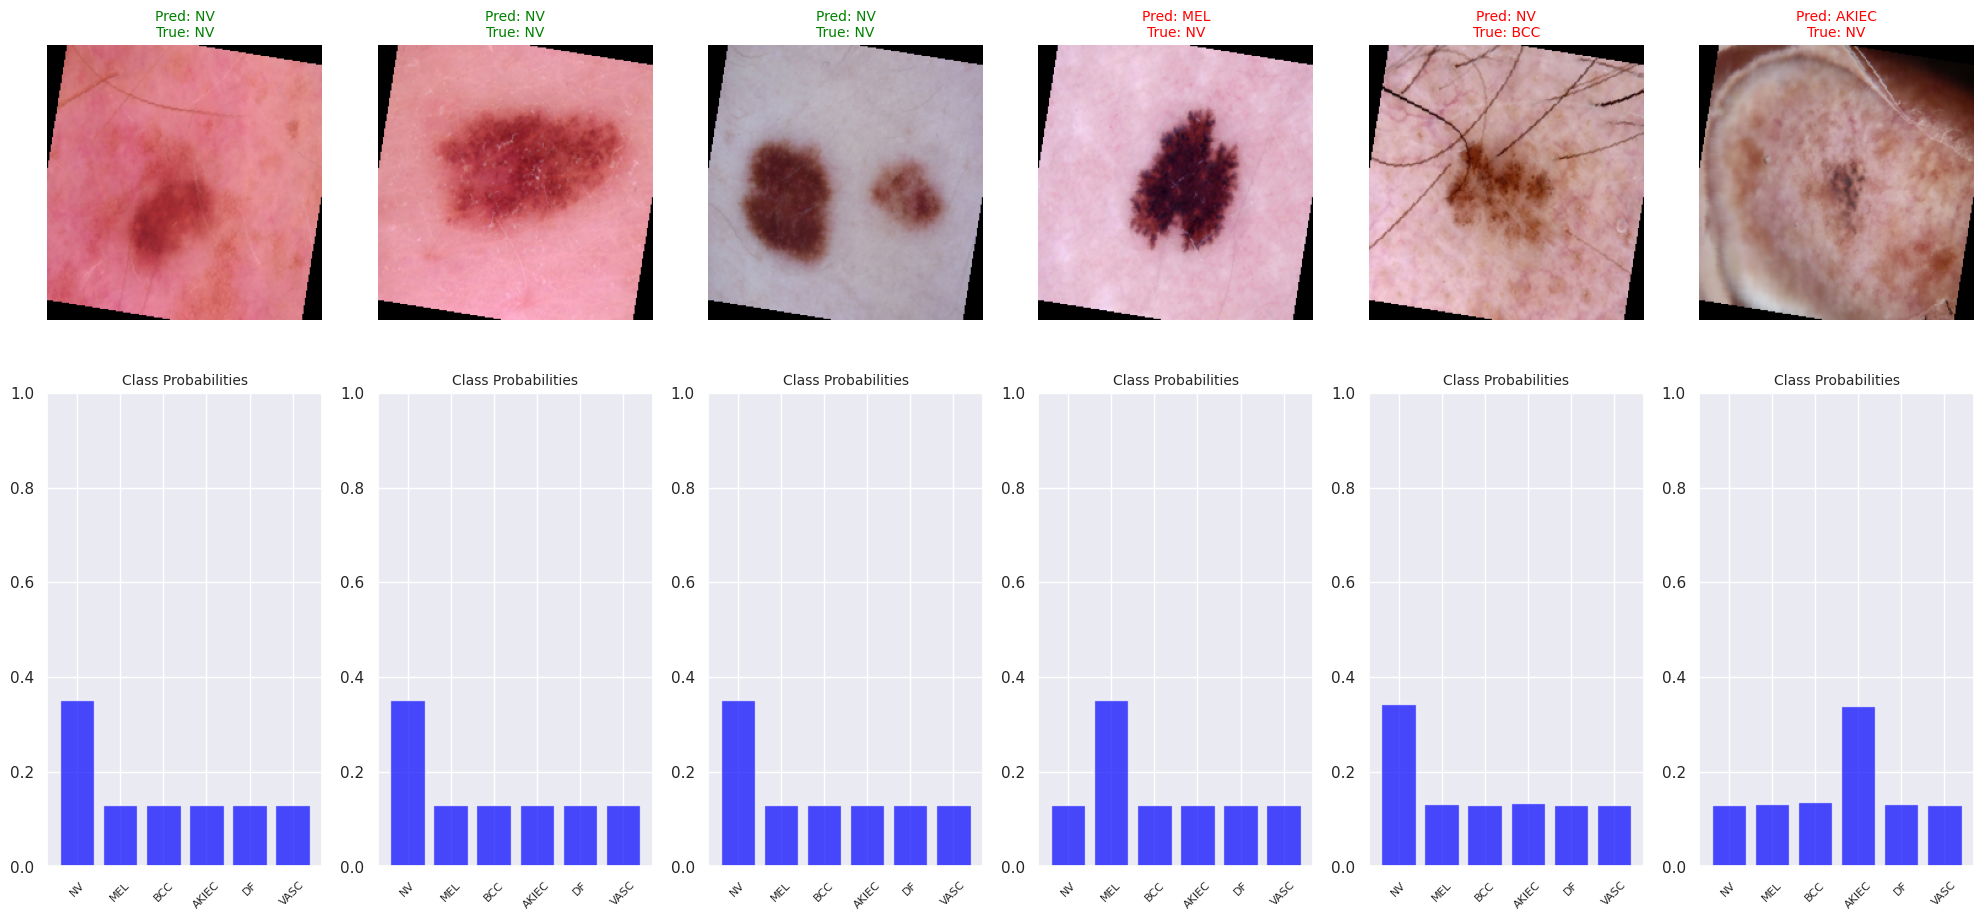

In [24]:
# Define function to visualize classified images with all class scores
def plot_classified_images_with_scores(model, dataloader, class_names, device, num_images=6):
    """
    Plot correctly and incorrectly classified images with their probabilities for all classes.

    Args:
    - model: Trained PyTorch model.
    - dataloader: DataLoader for the test dataset.
    - class_names: List of class names.
    - device: Computation device ('cuda' or 'cpu').
    - num_images: Number of images to plot (default: 6).
    """
    model.eval()
    all_images = []
    all_labels = []
    all_predictions = []
    all_probs = []

    # Collect predictions, true labels, and probabilities
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_predictions.append(preds.cpu())
            all_probs.append(probs.cpu())

    # Flatten lists
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_probs = torch.cat(all_probs, dim=0)

    # Identify correct and incorrect indices
    correct_indices = (all_predictions == all_labels).nonzero(as_tuple=True)[0]
    incorrect_indices = (all_predictions != all_labels).nonzero(as_tuple=True)[0]

    # # Select random correct and incorrect samples
    # # Generate choices
    # correct_sample_indices = np.random.choice(correct_indices, num_images // 2, replace=False)
    # incorrect_sample_indices = np.random.choice(incorrect_indices, num_images // 2, replace=False)
    # selected_indices = np.concatenate([correct_sample_indices, incorrect_sample_indices])

    # # Sort indices for reproducibility
    # correct_indices = torch.sort(correct_indices)[0]
    # incorrect_indices = torch.sort(incorrect_indices)[0]

    # # Select random correct and incorrect samples
    # np.random.seed(fixed_seed)  # Ensure reproducibility for the choice
    # correct_sample_indices = np.random.choice(correct_indices, num_images // 2, replace=False)
    # incorrect_sample_indices = np.random.choice(incorrect_indices, num_images // 2, replace=False)
    # selected_indices = np.concatenate([correct_sample_indices, incorrect_sample_indices])


    # Sort indices for reproducibility
    correct_indices = torch.sort(correct_indices)[0]
    incorrect_indices = torch.sort(incorrect_indices)[0]

    # Ensure consistent image selection
    num_correct_samples = min(len(correct_indices), num_images // 2)
    num_incorrect_samples = min(len(incorrect_indices), num_images // 2)

    correct_sample_indices = correct_indices[:num_correct_samples]
    incorrect_sample_indices = incorrect_indices[:num_incorrect_samples]

    selected_indices = torch.cat([correct_sample_indices, incorrect_sample_indices])

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))  # Two rows: images and bar plots
    for i, idx in enumerate(selected_indices):
        image = all_images[idx].permute(1, 2, 0).numpy()  # Convert to HWC format
        image = np.clip(image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Denormalize
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_predictions[idx]]
        pred_probs = all_probs[idx].numpy()

        # Image Plot
        ax_image = axes[0, i]
        ax_image.imshow(image)
        ax_image.axis('off')
        ax_image.set_title(
            f"Pred: {pred_label}\nTrue: {true_label}",
            color=("green" if all_predictions[idx] == all_labels[idx] else "red"),
            fontsize=10
        )

        # Bar Plot for Probabilities
        ax_bar = axes[1, i]
        ax_bar.bar(class_names, pred_probs, color='blue', alpha=0.7)
        ax_bar.set_ylim([0, 1])
        ax_bar.set_xticks(range(len(class_names)))
        ax_bar.set_xticklabels(class_names, rotation=45, fontsize=8)
        ax_bar.set_title("Class Probabilities", fontsize=10)

    plt.tight_layout()
    plt.show()


class_names = list(multiclass_categories.values())
plot_classified_images_with_scores(model_class, test_loader, class_names, device)

This plot shows 3 correctly (green text) and 3 incorrectly (red text) classified instances from the test set, as well as the class prediction probabilities corresponding to the classes. As we can see from the bar plots, the classification model usually assigns the highest probability (4 out of 6 cases) to class NV. (As we have mentioned before, the original dataset is heavily imbalanced towards the class “NV”.) However, even for this class the model is not so confident, as it assigns less than 0.4 probability to this class in all cases, and also 2 out of the 3 misclassified examples were “NV” samples misclassified as either a “MEL” or an “AKIEC” sample. Overall, we can see that the model is not so certain about its predictions, and this can be a valuable insight for both model builders & developers who would like to see how robust the classification model is, how uncertain it is about its predictions, and for non-experts (clinicians, doctors, or laypersons who are the users of different skin cancer detection apps) to properly calibrate their trust towards the skin cancer classification model.

### 3.1.2. Grad-Cam for the classification model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


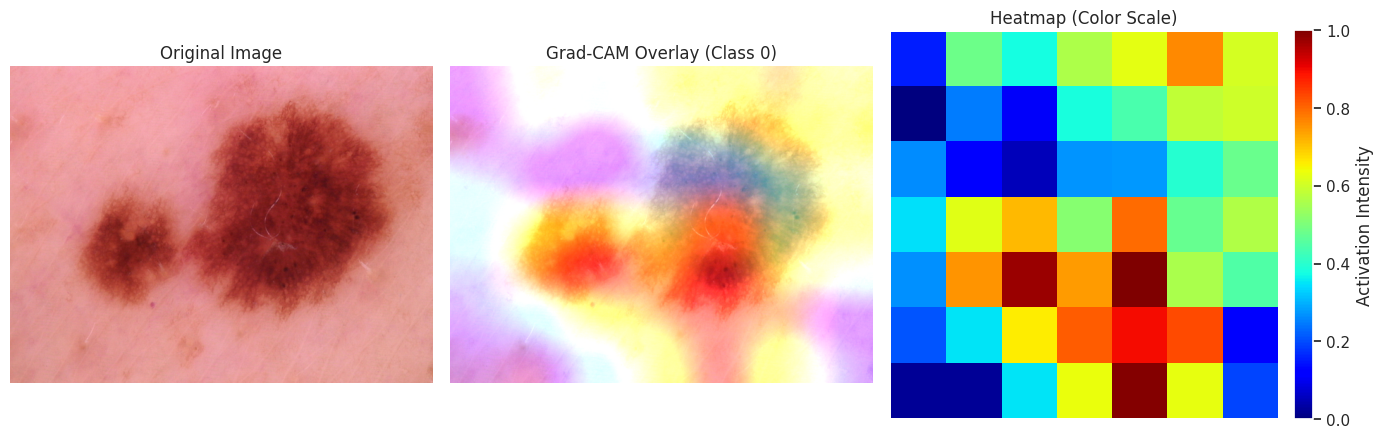

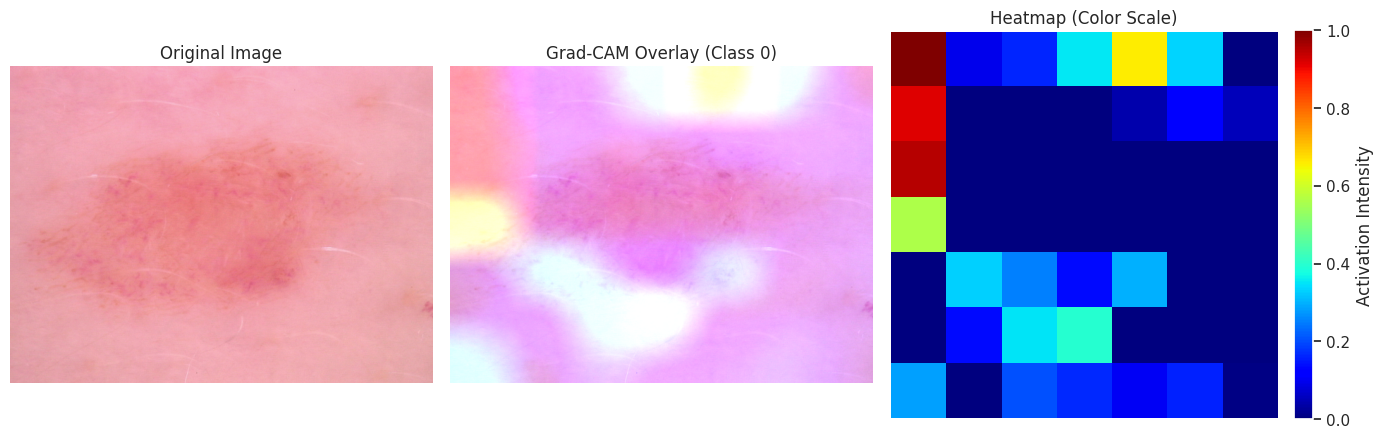

In [25]:
def preprocess_image(img_path, transform):
    """Load and preprocess an image for the model."""
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0)

def generate_gradcam_heatmap(model, img_tensor, target_class, last_conv_layer_name):
    """Generate Grad-CAM heatmap."""
    # Ensure model is in evaluation mode
    model.eval()

    # Hook to capture gradients
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the specified layer
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    last_conv_layer.register_forward_hook(forward_hook)
    last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    img_tensor = img_tensor.to(device)
    outputs = model(img_tensor)
    target_score = outputs[0, target_class]

    # Backward pass to compute gradients of the target class
    model.zero_grad()
    target_score.backward(retain_graph=True)

    # Extract gradients and activations
    grads = gradients[0].cpu().data.numpy()
    acts = activations[0].cpu().data.numpy()

    # Compute importance weights
    weights = np.mean(grads, axis=(2, 3))  # Global average pooling
    heatmap = np.sum(weights[:, :, np.newaxis, np.newaxis] * acts, axis=1).squeeze()

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    return heatmap

def overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6, colormap='jet'):
    """Overlay Grad-CAM heatmap on the original image."""
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.get_cmap(colormap)
    colored_heatmap = colormap(heatmap)
    colored_heatmap = np.delete(colored_heatmap, 3, axis=2)  # Remove alpha channel

    # Resize heatmap to original image dimensions
    colored_heatmap = Image.fromarray((colored_heatmap * 255).astype("uint8")).resize(original_image.size, Image.LANCZOS)
    colored_heatmap = np.array(colored_heatmap) / 255.0  # Normalize to [0, 1]

    # Superimpose the heatmap onto the original image
    original_image = np.array(original_image) / 255.0
    superimposed_image = colored_heatmap * alpha + original_image
    superimposed_image = np.clip(superimposed_image, 0, 1)
    return (superimposed_image * 255).astype("uint8")

# EASY IMAGE
# Load and preprocess the image
#image_path = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ISIC_0024317.jpg"  # ISIC_0024624.jpg
image_path = "/content/extracted_folder/images/ISIC_0024810.jpg"  # ISIC_0024624.jpg
original_image = Image.open(image_path).convert("RGB")
img_tensor = preprocess_image(image_path, transform)

# Generate Grad-CAM heatmap
target_class = 0  # Update to the desired class index
last_conv_layer_name = "model.features.11.block"
heatmap = generate_gradcam_heatmap(model_class, img_tensor, target_class, last_conv_layer_name)

# Overlay Grad-CAM heatmap on the original image
superimposed_image = overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6)

# Display the results
plt.figure(figsize=(14, 7))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
plt.subplot(1, 3, 2)
plt.imshow(superimposed_image)
plt.title(f"Grad-CAM Overlay (Class {target_class})")
plt.axis("off")

# Heatmap with Colorbar
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap (Color Scale)")
plt.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label("Activation Intensity")

plt.tight_layout()
plt.show()

# CHALLENGING IMAGE
#image_path_2 = "/content/drive/My Drive/AI_and_Vis/A2_data_from_Kaggle/extracted_images_and_masks/images/ISIC_0024624.jpg"
image_path_2 = "/content/extracted_folder/images/ISIC_0024354.jpg"
original_image = Image.open(image_path_2).convert("RGB")
img_tensor = preprocess_image(image_path_2, transform)

# Generate Grad-CAM heatmap
target_class = 0  # Update to the desired class index
last_conv_layer_name = "model.features.11.block"
heatmap = generate_gradcam_heatmap(model_class, img_tensor, target_class, last_conv_layer_name)

# Overlay Grad-CAM heatmap on the original image
superimposed_image = overlay_gradcam_heatmap(heatmap, original_image, alpha=0.6)

# Display the results
plt.figure(figsize=(14, 7))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
plt.subplot(1, 3, 2)
plt.imshow(superimposed_image)
plt.title(f"Grad-CAM Overlay (Class {target_class})")
plt.axis("off")

# Heatmap with Colorbar
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap (Color Scale)")
plt.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="jet"), ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label("Activation Intensity")

plt.tight_layout()
plt.show()

These Grad-CAM plots visualize the regions of input images (above input image with sharp bordered lesion, below input image with blurry bordered lesion) that contributed most to the model's prediction for class „NV” (0). Moreover, the accompanying heatmaps provide an even clearer activation intensity for different regions of the input images. As we can see, for a sharp bordered lesion, the classification model mainly focuses on the lesion itself (which is clinically relevant as lesion shapes, colors etc. can be good indicators for the lesion being cancerous or not) and less on the surrounding skin, however for a blurry bordered lesion it tends to rather find the surrounding skin relevant and not the lesion itself, so in this case the model focuses mainly on irrelevant background regions. These insights are extremely important for model builders & developers when evaluating their model’s robustness and reliability, as well as to non-experts (clinicians, doctors, or laypersons who are the users of different skin cancer detection apps) for interpretability and calibrating proper trust in the skin cancer classification model.

### 3.1.3. LIME for the classification model

  0%|          | 0/1000 [00:00<?, ?it/s]

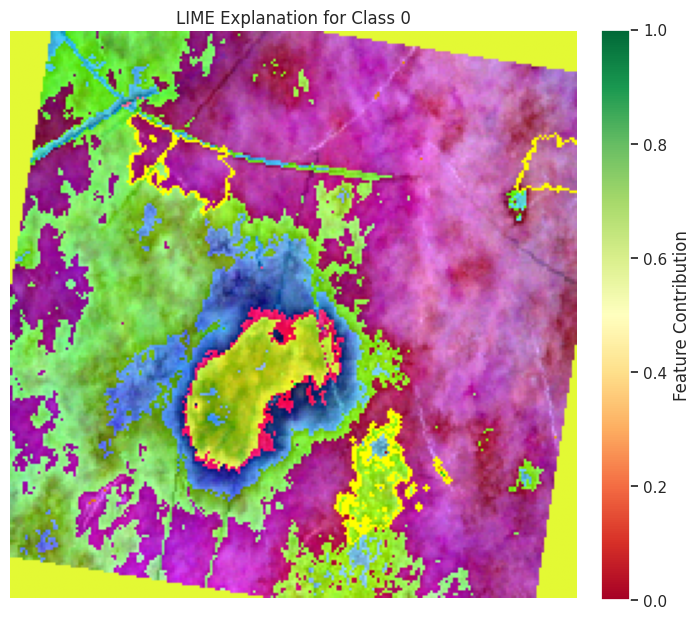

In [45]:
torch.cuda.empty_cache()

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
def predict_fn(images):
    images = [transform(transforms.ToPILImage()(img)) for img in images]  # Transform on CPU
    images = torch.stack(images).to(device)  # Then move to GPU
    with torch.no_grad():
        outputs = model_class(images)
    torch.cuda.empty_cache()  # Clear unused memory
    return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=1000
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=False
)

# Visualize the explanation using mark_boundaries to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
cmap = plt.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
# norm = mpl.colors.Normalize(vmin=0, vmax=1)  # Normalize the color scale to [0, 1]

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

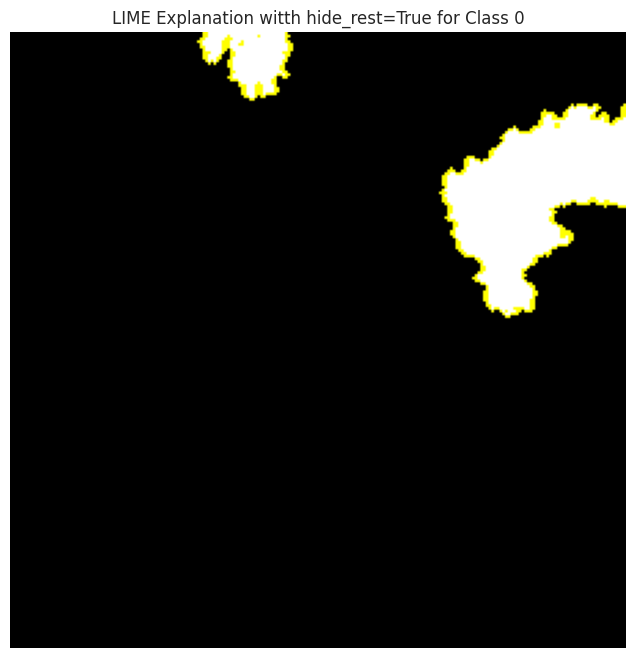

In [50]:
# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Test LIME on a single image
image, label = test_dataset.__getitem__(0)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=300
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=True
)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation witth hide_rest=True for Class {label}')
ax.axis('off')

# Display the plot
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

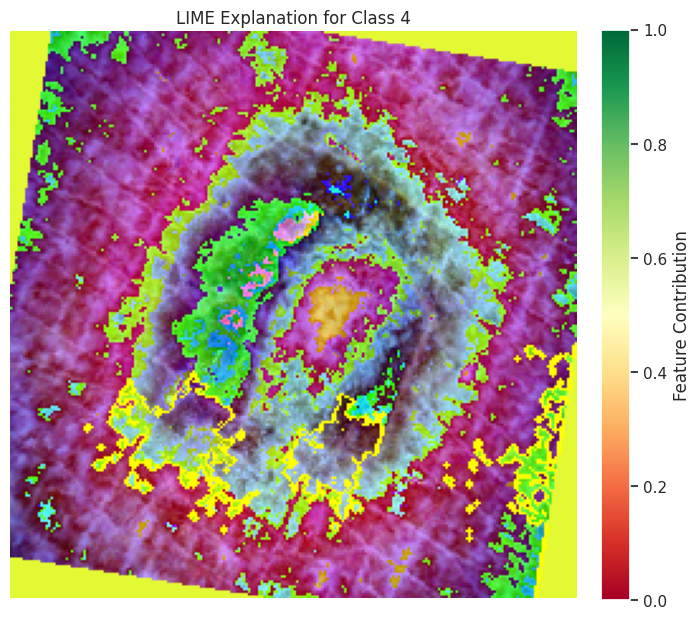

In [51]:
# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Test LIME on a single image
image, label = test_dataset.__getitem__(122)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=300
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=False
)

# Visualize the explanation using mark_boundaries to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation for Class {label}')
ax.axis('off')

# Create a colorbar to show positive and negative contributions
cmap = plt.cm.RdYlGn  # Red-Yellow-Green color map, with red for negative and green for positive
# norm = mpl.colors.Normalize(vmin=0, vmax=1)  # Normalize the color scale to [0, 1]

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Create a dummy array for the color bar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Feature Contribution')

# Display the plot
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

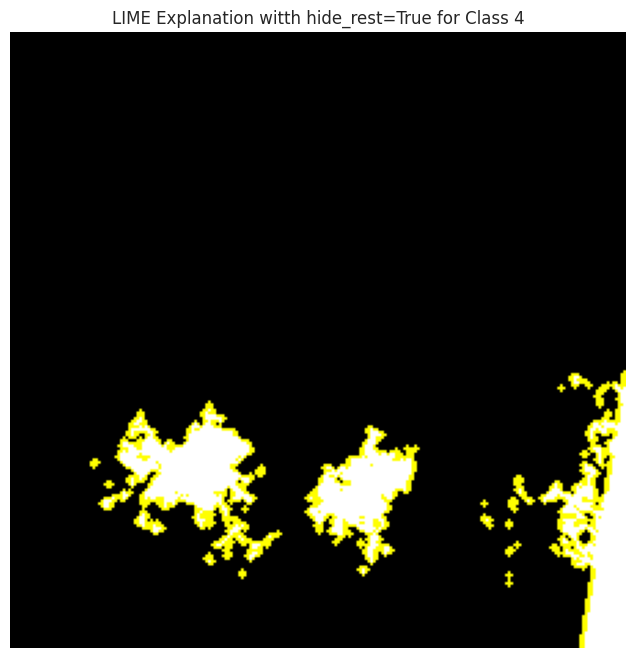

In [52]:
# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

# Predict function for LIME
# def predict_fn(images):
#     images = torch.stack([transform(transforms.ToPILImage()(img)) for img in images])
#     images = images.to(device)
#     outputs = model_class(images)
#     return outputs.cpu().detach().numpy()

# Test LIME on a single image
image, label = test_dataset.__getitem__(122)
image_np = np.array(transforms.ToPILImage()(image))

# Generate explanation
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    labels=[label],
    hide_color=0,
    num_samples=300
)

# Get the explanation for the specific class label
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,  # Only show positive contributions
    num_features=3,  # Number of features (segments) to show
    hide_rest=True
)

# Visualize the explanation using `mark_boundaries` to overlay the mask on the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(temp, mask))

# Title
ax.set_title(f'LIME Explanation witth hide_rest=True for Class {label}')
ax.axis('off')

# Display the plot
plt.show()

### 3.1.4 Entropy visualization

In [37]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

model = MobileNetV3(num_classes=6)

model.load_state_dict(torch.load("/content/drive/MyDrive/XAI/best_model_classification.pth", map_location=torch.device('cpu')))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-37-52c42faf06a3>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-m

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

NV Entropy:0.12493987881531567, Nr. of classified images: 5419
MEL Entropy:0.23018173988135066, Nr. of classified images: 2340
BCC Entropy:0.29259641102033584, Nr. of classified images: 551
AKIEC Entropy:0.3047801893422042, Nr. of classified images: 656
DF Entropy:0.4340517743669074, Nr. of classified images: 194
VASC Entropy:0.17189825866071967, Nr. of classified images: 855


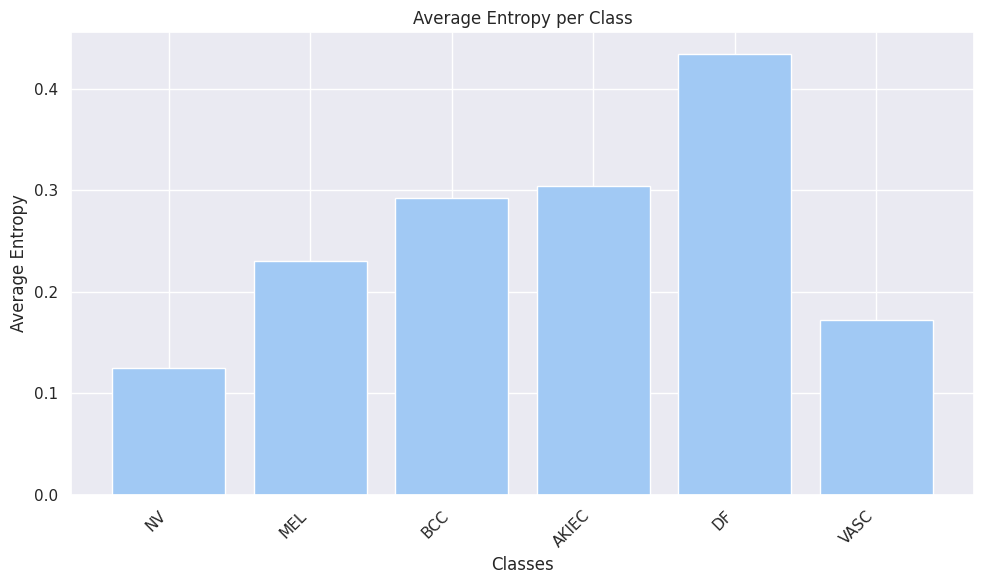

In [38]:
def calculate_entropy(probs):
    """Compute entropy for a probability distribution."""
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=1)  # Add epsilon for numerical stability


def preprocess_image(image_path):
    """Preprocess image for MobileNetV3."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for ImageNet
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

folder_path = "/content/extracted_folder/images"
image_extensions = {'.jpg'}

labels = ['NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']
NV_ent = []
MEL_ent = []
BCC_ent = []
AKIEC_ent = []
DF_ent = []
VASC_ent = []

def predict_with_uncert(model, image_path):
    """Get class probabilities and uncertainty scores for an image."""
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        probs = model(image_tensor)
        entropy = calculate_entropy(probs)

    labels = ['NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']


    return probs, entropy

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    #print(file_path)

    # Check if the file is an image
    if os.path.isfile(file_path) and os.path.splitext(file_name)[1].lower() in image_extensions:
        # Call the function for the image
        probs, entropy = predict_with_uncert(model, file_path)
        max_index = torch.argmax(probs, dim=1).item()
        #print(probs)
        #print(max_index)

        # Get the label corresponding to the highest value
        max_label = labels[max_index]

        if max_label == labels[0]:
          NV_ent.append(entropy.item())
        if max_label == labels[1]:
          MEL_ent.append(entropy.item())
        if max_label == labels[2]:
          BCC_ent.append(entropy.item())
        if max_label == labels[3]:
          AKIEC_ent.append(entropy.item())
        if max_label == labels[4]:
          DF_ent.append(entropy.item())
        if max_label == labels[5]:
          VASC_ent.append(entropy.item())


NV_entropy = np.mean(NV_ent)
MEL_entropy = np.mean(MEL_ent)
BCC_entropy = np.mean(BCC_ent)
AKIEC_entropy = np.mean(AKIEC_ent)
DF_entropy = np.mean(DF_ent)
VASC_entropy = np.mean(VASC_ent)

print(f"NV Entropy:{NV_entropy}, Nr. of classified images: {len(NV_ent)}")
print(f"MEL Entropy:{MEL_entropy}, Nr. of classified images: {len(MEL_ent)}")
print(f"BCC Entropy:{BCC_entropy}, Nr. of classified images: {len(BCC_ent)}")
print(f"AKIEC Entropy:{AKIEC_entropy}, Nr. of classified images: {len(AKIEC_ent)}")
print(f"DF Entropy:{DF_entropy}, Nr. of classified images: {len(DF_ent)}")
print(f"VASC Entropy:{VASC_entropy}, Nr. of classified images: {len(VASC_ent)}")

import matplotlib.pyplot as plt

entropies = {
    'NV': NV_entropy,
    'MEL': MEL_entropy,
    'BCC': BCC_entropy,
    'AKIEC': AKIEC_entropy,
    'DF': DF_entropy,
    'VASC': VASC_entropy
}

# Extract labels and values for plotting
labels = list(entropies.keys())
values = list(entropies.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel("Classes")
plt.ylabel("Average Entropy")
plt.title("Average Entropy per Class")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()

In this plot, the average entropy for each class is shown, indicating how certain the model is about the classifications for the individual classes. For the class “melanocytic nevi” (NV), for example, the average entropy is lower than for all other classes. This indicates that predictions for this class have the lowest uncertainty. The class “dermatofibroma” (DF), in contrast, has a higher average entropy. Consequently, the model is rather unsure about the DF classifications. Model developers could especially focus on this class to decrease the uncertainty of the model.

## 3.2 XAI approaches for the segmentation model

### 3.2.1 Grad-Cam for different layers of the network

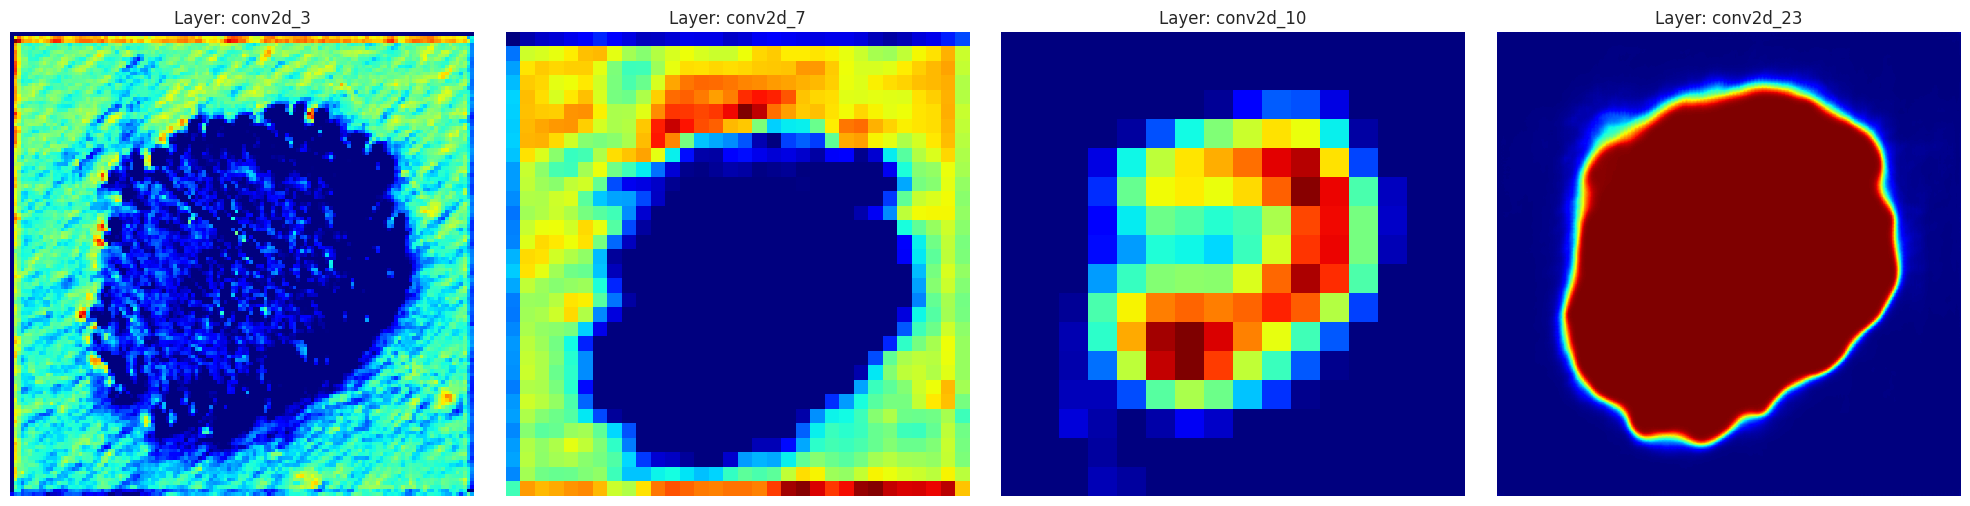

In [39]:
# Ensure Keras backend is TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

# Use your fuzzy net segmentation model
model_path = "/content/drive/MyDrive/XAI/Skin_cancer_Segmentation.keras"  # Update with your model file path
model_seg = load_model(model_path, custom_objects={"dice_coefficient": dice_coefficient, "iou": iou})

# Update the last convolutional layer name for your fuzzy net model
#last_conv_layer_name = "conv2d_23"  # Update based on your model architecture

# Load and preprocess the input image
def preprocess_input(img_path, target_size=(256, 256)):
    """Load and preprocess an image for the model."""
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)

# Grad-CAM heatmap generation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, target_class=None):
    """Generate a Grad-CAM heatmap for a segmentation model."""
    # Create a model mapping input to last conv layer and output
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients for the target class
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)

        # Use the first class if none is provided
        if target_class is None:
            target_class = 0  # For binary segmentation

        # Focus on the target class across the entire output
        class_channel = predictions[..., target_class]

    # Compute gradients of the class channel wrt the feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients to get global importance of each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature map by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualize the Grad-CAM heatmap
def overlay_heatmap(heatmap, img, alpha=0.5, colormap="jet"):
    """Overlay the Grad-CAM heatmap on the original image."""
    heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
    colormap = plt.get_cmap(colormap)
    colored_heatmap = colormap(heatmap)
    colored_heatmap = np.delete(colored_heatmap, 3, axis=2)  # Remove alpha channel
    colored_heatmap = tf.image.resize(colored_heatmap, (img.shape[0], img.shape[1])).numpy()
    superimposed_img = colored_heatmap * alpha + img / 255.0  # Normalize original image
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return (superimposed_img * 255).astype("uint8")

# List of layers to compare
layer_names = [
    "conv2d_3",  # Early layer
    "conv2d_7",  # Mid layer
    "conv2d_10",  # Mid layer
    "conv2d_23"  # Final layer
]

# Function to generate and plot Grad-CAM for multiple layers
def plot_gradcam_for_layers(model, img_array, layer_names, target_class=0):
    """Plot Grad-CAM heatmaps for a list of layers."""
    num_layers = len(layer_names)
    fig, axes = plt.subplots(1, num_layers, figsize=(20, 5))

    for i, layer_name in enumerate(layer_names):
        # Generate Grad-CAM heatmap for the layer
        heatmap = make_gradcam_heatmap(img_array, model, layer_name, target_class=target_class)

        # Plot heatmap
        axes[i].imshow(heatmap, cmap="jet")
        axes[i].set_title(f"Layer: {layer_name}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Preprocess the input image
img_path = "/content/extracted_folder/images/ISIC_0024317.jpg"  # Path to your image
img_array = preprocess_input(img_path, target_size=(256, 256))

# Call the function
plot_gradcam_for_layers(model_seg, img_array, layer_names, target_class=0)

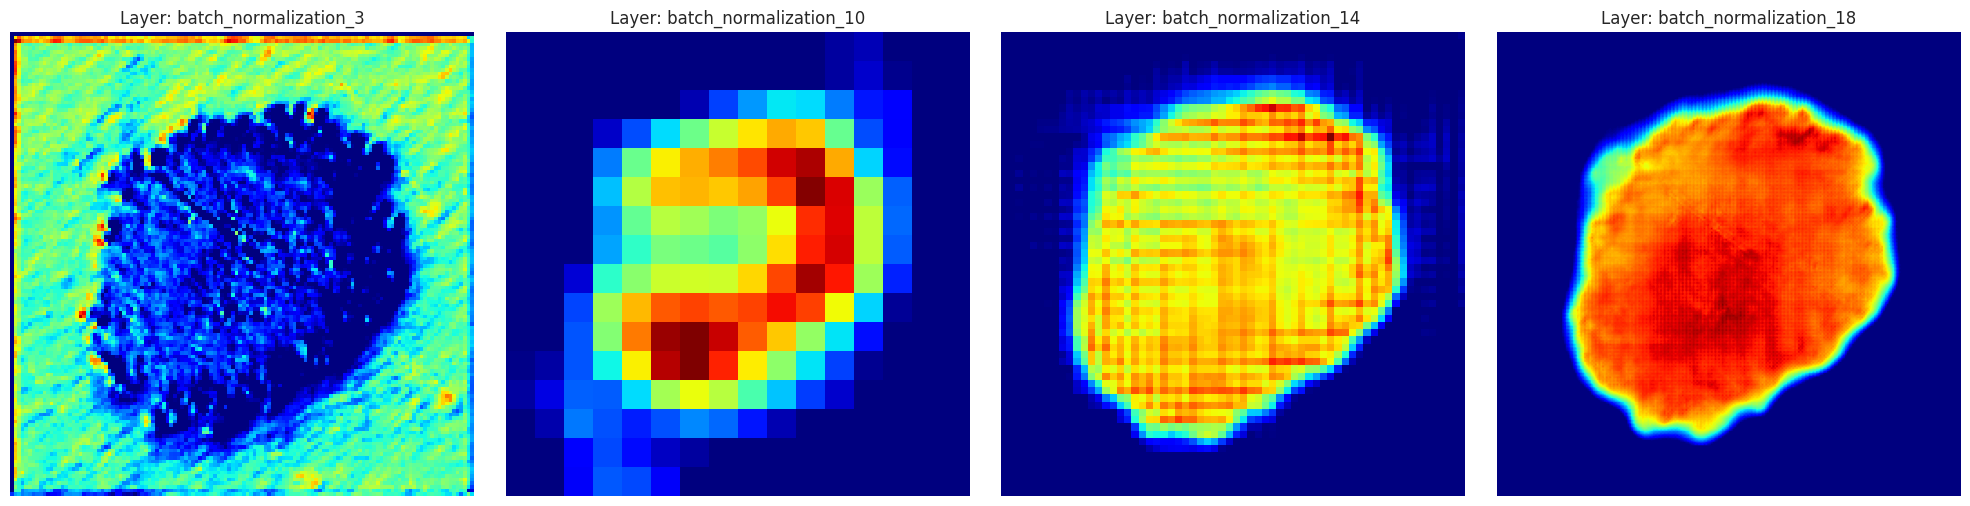

In [40]:
# List of layers to compare
layer_names = [
    "batch_normalization_3",  # Early layer
    "batch_normalization_10",  # Mid layer
    "batch_normalization_14",  # Mid layer
    "batch_normalization_18"  # Final layer
]

# Function to generate and plot Grad-CAM for multiple layers
def plot_gradcam_for_layers(model, img_array, layer_names, target_class=0):
    """Plot Grad-CAM heatmaps for a list of layers."""
    num_layers = len(layer_names)
    fig, axes = plt.subplots(1, num_layers, figsize=(20, 5))

    for i, layer_name in enumerate(layer_names):
        # Generate Grad-CAM heatmap for the layer
        heatmap = make_gradcam_heatmap(img_array, model, layer_name, target_class=target_class)

        # Plot heatmap
        axes[i].imshow(heatmap, cmap="jet")
        axes[i].set_title(f"Layer: {layer_name}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Preprocess the input image
img_path = "/content/extracted_folder/images/ISIC_0024317.jpg"
img_array = preprocess_input(img_path, target_size=(256, 256))

# Call the function
plot_gradcam_for_layers(model_seg, img_array, layer_names, target_class=0)

**Conclusion**

The Grad-CAM visualizations across the Fuzzy U-Net layers reveal a clear progression of feature learning. Early layers focus on low-level features such as texture and edges, while mid-layers refine attention toward lesion-specific patterns like pigmentation and borders. Late layers exhibit precise boundary detection, aligning closely with the lesion's ground truth.

**These insights are critical for:**

* Model Debugging: Ensuring the network learns relevant features at different stages.
* Trust Building: Demonstrating that the model focuses on clinically meaningful regions, enhancing confidence in predictions.
* Performance Validation: Comparing the segmentation quality across layers to refine architecture or training methods.


Grad-CAM provides a powerful interpretability tool for segmentation models, aiding machine learning practitioners, clinicians, and researchers in understanding and improving model behavior.

 ### 3.2.2 Occlusion sensitivity

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

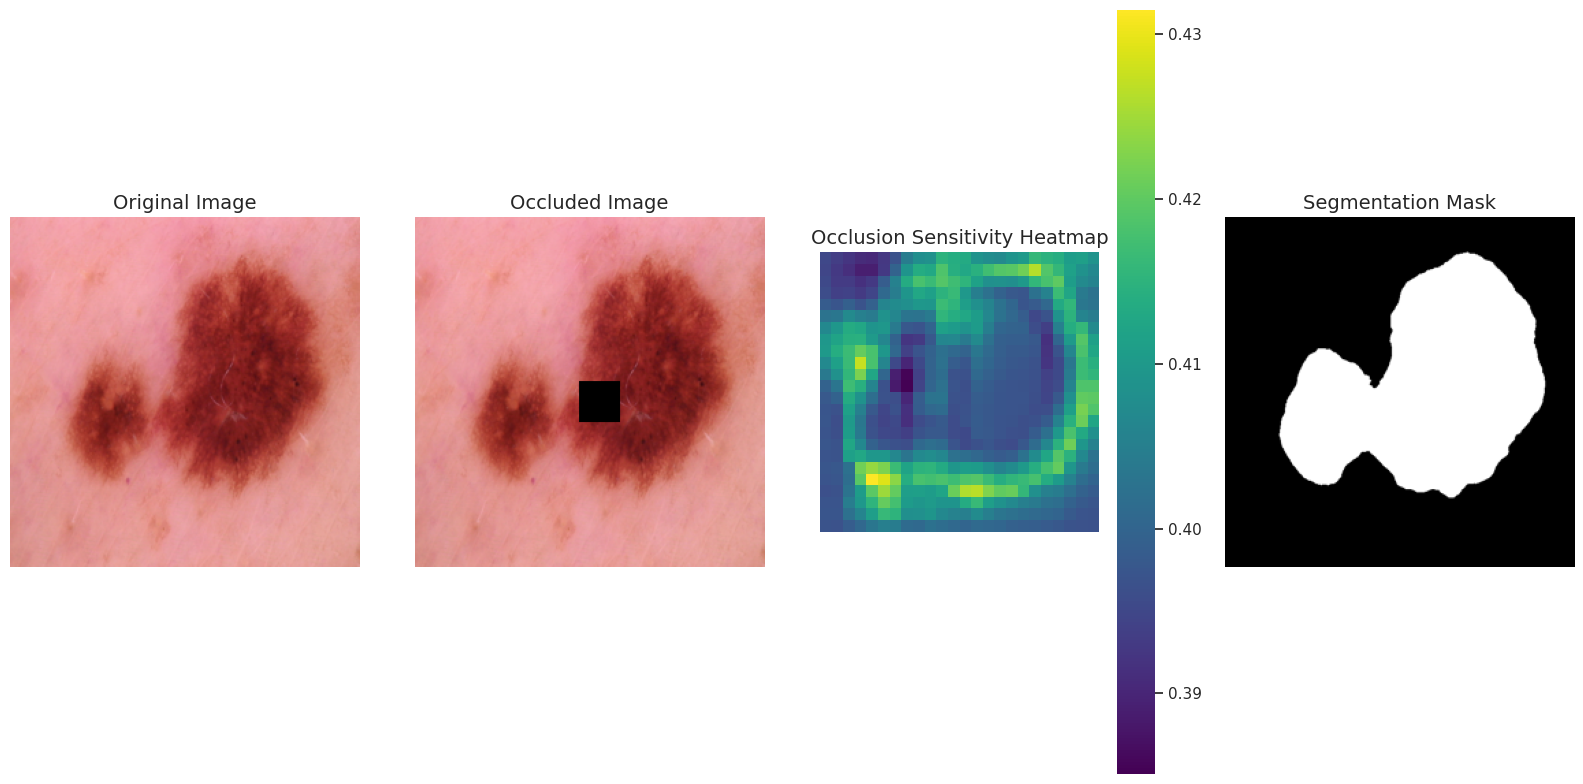

In [41]:
# Parameters for occlusion
occluding_size = 30  # Size of the occluding patch
occluding_pixel = (0, 0, 0)  # Pixel value for occlusion (black in RGB)
occluding_stride = 10  # Stride for occlusion

def preprocess_image(img_path, target_size=(256, 256)):
    """
    Preprocess the input image for the model using Pillow.
    """
    image = Image.open(img_path).resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, target_size=(256, 256)):
    """
    Load the segmentation mask from the given path.
    """
    mask = Image.open(mask_path).resize(target_size)
    mask = np.array(mask) / 255.0  # Normalize mask values to [0, 1]
    return mask

def occlusion_sensitivity(image, model, target_class=0, occluding_size=50, occluding_pixel=(0, 0, 0), occluding_stride=10):
    """
    Perform occlusion sensitivity analysis.

    Args:
        image: Input image as a NumPy array.
        model: Pre-trained model.
        target_class: Target class index (default: 0 for binary).
        occluding_size: Size of the occlusion patch.
        occluding_pixel: RGB tuple for occlusion (default: black).
        occluding_stride: Stride of occlusion.

    Returns:
        heatmap: Occlusion sensitivity heatmap.
        occluded_example: An example of the occluded image at the final position.
    """
    # Get image dimensions
    height, width, _ = image.shape

    # Calculate heatmap dimensions
    output_height = math.ceil((height - occluding_size) / occluding_stride + 1)
    output_width = math.ceil((width - occluding_size) / occluding_stride + 1)
    heatmap = np.zeros((int(output_height), int(output_width)))

    # Create an occluded example for visualization
    occluded_example = None

    for h in range(0, int(output_height)):
        for w in range(0, int(output_width)):
            # Calculate occlusion region
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)

            # Create a copy of the image and apply the occlusion
            occluded_image = copy.deepcopy(image)
            occluded_image[h_start:h_end, w_start:w_end, :] = occluding_pixel

            # Preprocess the occluded image and predict
            input_image = np.expand_dims(occluded_image, axis=0)  # Add batch dimension
            predictions = model.predict(input_image)

            # Record the probability for the target class
            prob = predictions[0][..., target_class].mean()  # Adjust for segmentation
            heatmap[h, w] = prob

            # Save one example occluded image for visualization
            if h == int(output_height / 2) and w == int(output_width / 2):
                occluded_example = occluded_image

    return heatmap, occluded_example

# Path to the input image and mask
img_path = "/content/extracted_folder/images/ISIC_0024810.jpg"
mask_path = "/content/extracted_folder/masks/ISIC_0024810_segmentation.png"

# Preprocess the image and mask
original_img = preprocess_image(img_path, target_size=(256, 256))
segmentation_mask = load_mask(mask_path, target_size=(256, 256))


# Generate occlusion sensitivity heatmap
sensitivity_heatmap, occluded_example = occlusion_sensitivity(
    original_img,
    model_seg,
    target_class=0,  # For binary segmentation
    occluding_size=occluding_size,
    occluding_pixel=occluding_pixel,
    occluding_stride=occluding_stride
)

# Plot the results with improved layout and resizing
plt.figure(figsize=(16, 8))  # Adjust the figure size for better visualization

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image", fontsize=14)
plt.axis("off")

# Occluded Image
plt.subplot(1, 4, 2)
plt.imshow(occluded_example)
plt.title("Occluded Image", fontsize=14)
plt.axis("off")

# Sensitivity Heatmap
plt.subplot(1, 4, 3)
sns.heatmap(sensitivity_heatmap, cmap="viridis", cbar=True, xticklabels=False, yticklabels=False, square=True)
plt.title("Occlusion Sensitivity Heatmap", fontsize=14)
plt.axis("off")

# Segmentation Mask
plt.subplot(1, 4, 4)
plt.imshow(segmentation_mask, cmap="gray")
plt.title("Segmentation Mask", fontsize=14)
plt.axis("off")

# Tighten layout for better spacing
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

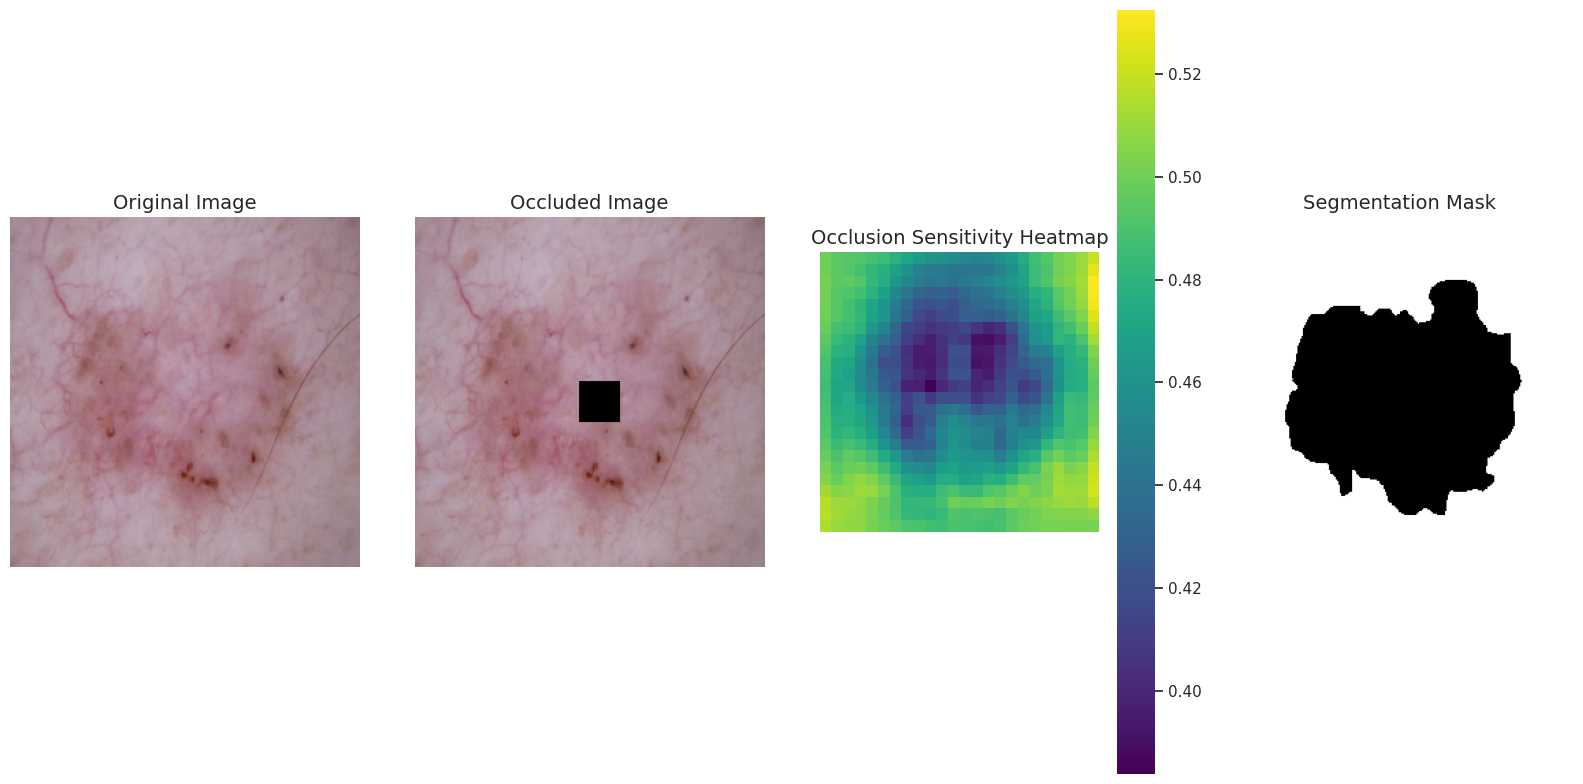

In [42]:
# Parameters for occlusion
occluding_size = 30  # Size of the occluding patch
occluding_pixel = (0, 0, 0)  # Pixel value for occlusion (black in RGB)
occluding_stride = 10  # Stride for occlusion

def preprocess_image(img_path, target_size=(256, 256)):
    """
    Preprocess the input image for the model using Pillow.
    """
    image = Image.open(img_path).resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, target_size=(256, 256)):
    """
    Load the segmentation mask from the given path.
    """
    mask = Image.open(mask_path).resize(target_size)
    mask = np.array(mask) / 255.0  # Normalize mask values to [0, 1]
    return mask

def occlusion_sensitivity(image, model, target_class=0, occluding_size=50, occluding_pixel=(0, 0, 0), occluding_stride=10):
    """
    Perform occlusion sensitivity analysis.

    Args:
        image: Input image as a NumPy array.
        model: Pre-trained model.
        target_class: Target class index (default: 0 for binary).
        occluding_size: Size of the occlusion patch.
        occluding_pixel: RGB tuple for occlusion (default: black).
        occluding_stride: Stride of occlusion.

    Returns:
        heatmap: Occlusion sensitivity heatmap.
        occluded_example: An example of the occluded image at the final position.
    """
    # Get image dimensions
    height, width, _ = image.shape

    # Calculate heatmap dimensions
    output_height = math.ceil((height - occluding_size) / occluding_stride + 1)
    output_width = math.ceil((width - occluding_size) / occluding_stride + 1)
    heatmap = np.zeros((int(output_height), int(output_width)))

    # Create an occluded example for visualization
    occluded_example = None

    for h in range(0, int(output_height)):
        for w in range(0, int(output_width)):
            # Calculate occlusion region
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)

            # Create a copy of the image and apply the occlusion
            occluded_image = copy.deepcopy(image)
            occluded_image[h_start:h_end, w_start:w_end, :] = occluding_pixel

            # Preprocess the occluded image and predict
            input_image = np.expand_dims(occluded_image, axis=0)  # Add batch dimension
            predictions = model.predict(input_image)

            # Record the probability for the target class
            prob = predictions[0][..., target_class].mean()  # Adjust for segmentation
            heatmap[h, w] = prob

            # Save one example occluded image for visualization
            if h == int(output_height / 2) and w == int(output_width / 2):
                occluded_example = occluded_image

    return heatmap, occluded_example

# Path to the input image and mask
img_path = "/content/extracted_folder/images/ISIC_0024448.jpg"
mask_path = "/content/extracted_folder/masks/ISIC_0024448_segmentation.png"

# Preprocess the image and mask
original_img = preprocess_image(img_path, target_size=(256, 256))
segmentation_mask = load_mask(mask_path, target_size=(256, 256))


# Generate occlusion sensitivity heatmap
sensitivity_heatmap, occluded_example = occlusion_sensitivity(
    original_img,
    model_seg,
    target_class=0,  # For binary segmentation
    occluding_size=occluding_size,
    occluding_pixel=occluding_pixel,
    occluding_stride=occluding_stride
)

# Plot the results with improved layout and resizing
plt.figure(figsize=(16, 8))  # Adjust the figure size for better visualization

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image", fontsize=14)
plt.axis("off")

# Occluded Image
plt.subplot(1, 4, 2)
plt.imshow(occluded_example)
plt.title("Occluded Image", fontsize=14)
plt.axis("off")

# Sensitivity Heatmap
plt.subplot(1, 4, 3)
sns.heatmap(sensitivity_heatmap, cmap="viridis", cbar=True, xticklabels=False, yticklabels=False, square=True)
plt.title("Occlusion Sensitivity Heatmap", fontsize=14)
plt.axis("off")

# Segmentation Mask
plt.subplot(1, 4, 4)
plt.imshow(segmentation_mask, cmap="gray")
plt.title("Segmentation Mask", fontsize=14)
plt.axis("off")

# Tighten layout for better spacing
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

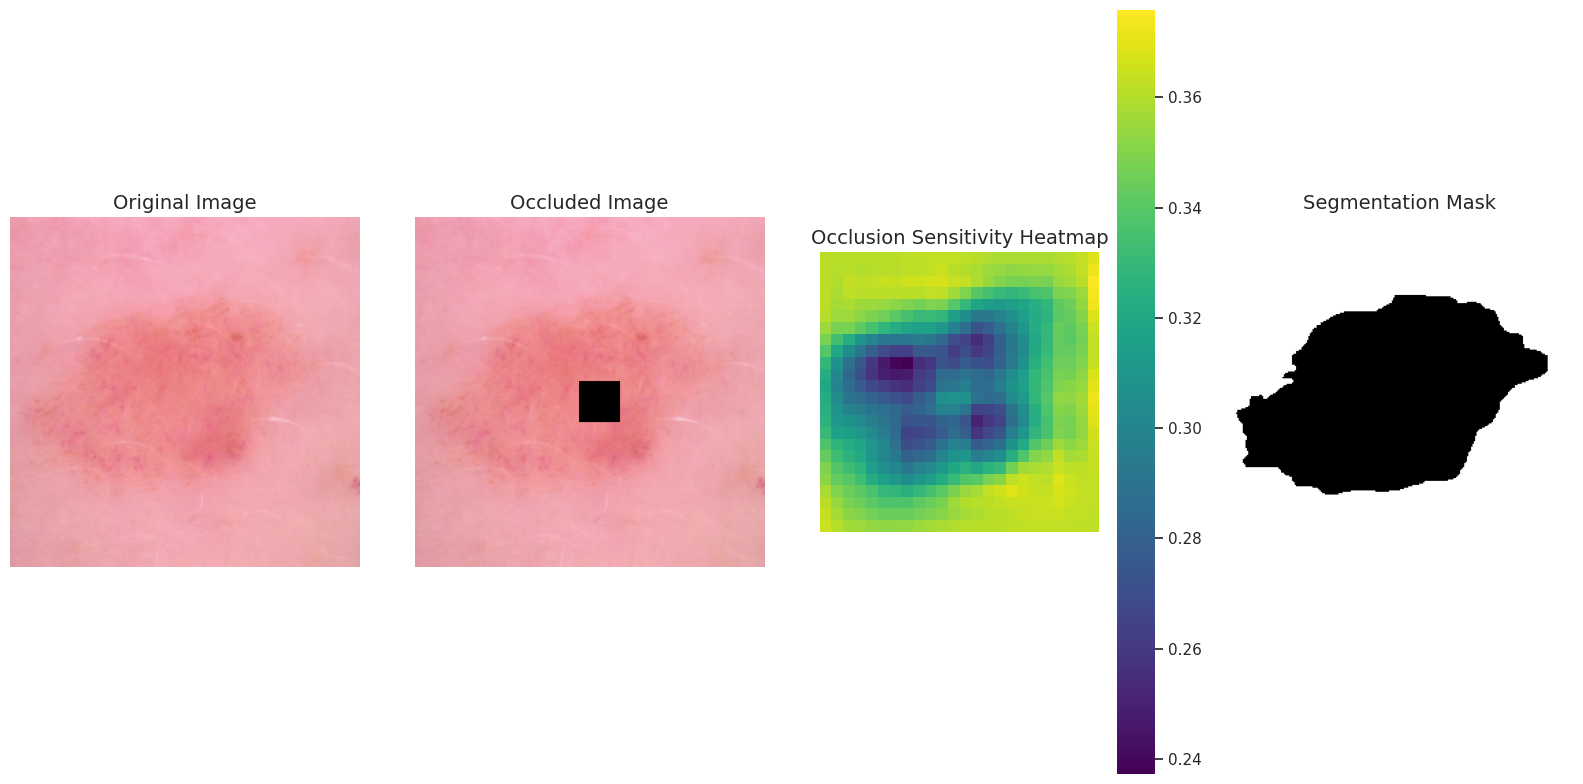

In [43]:
# Parameters for occlusion
occluding_size = 30  # Size of the occluding patch
occluding_pixel = (0, 0, 0)  # Pixel value for occlusion (black in RGB)
occluding_stride = 10  # Stride for occlusion


# Path to the input image and mask
img_path = "/content/extracted_folder/images/ISIC_0024354.jpg"
mask_path = "/content/extracted_folder/masks/ISIC_0024354_segmentation.png"

# Preprocess the image and mask
original_img = preprocess_image(img_path, target_size=(256, 256))
segmentation_mask = load_mask(mask_path, target_size=(256, 256))

# Generate occlusion sensitivity heatmap
sensitivity_heatmap, occluded_example = occlusion_sensitivity(
    original_img,
    model_seg,
    target_class=0,  # For binary segmentation
    occluding_size=occluding_size,
    occluding_pixel=occluding_pixel,
    occluding_stride=occluding_stride
)

# Plot the results with improved layout and resizing
plt.figure(figsize=(16, 8))  # Adjust the figure size for better visualization

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image", fontsize=14)
plt.axis("off")

# Occluded Image
plt.subplot(1, 4, 2)
plt.imshow(occluded_example)
plt.title("Occluded Image", fontsize=14)
plt.axis("off")

# Sensitivity Heatmap
plt.subplot(1, 4, 3)
sns.heatmap(sensitivity_heatmap, cmap="viridis", cbar=True, xticklabels=False, yticklabels=False, square=True)
plt.title("Occlusion Sensitivity Heatmap", fontsize=14)
plt.axis("off")

# Segmentation Mask
plt.subplot(1, 4, 4)
plt.imshow(segmentation_mask, cmap="gray")
plt.title("Segmentation Mask", fontsize=14)
plt.axis("off")

# Tighten layout for better spacing
plt.tight_layout()
plt.show()

### Conclusion

In the heatmaps:
* Yellow regions indicate areas where occlusion has a significant impact on the model’s segmentation performance.
* Blue regions indicate areas where occlusion has little to no effect.

First example:
* The lesion is clearly visible, with irregular pigmentation and boundaries.
* The occlusion sensitivity heatmap strongly highlights the lesion boundaries, indicating that the model is paying significant attention to these region for its predictions.

Second and Third example:

* The lesion is more subtle, with diffuse pigmentation and less clear boundaries.
* The heatmap shows less focused and more dispersed attention, with less solid and sharp lesion borders.
* This could indicate that the model is uncertain about the lesion's boundaries, possibly due to: Vairablility in the lesion's texture and color.
* The mask aligns with the sensitive central area, though the lack of sensitivity at the edges may indicate potential weaknesses in boundary detection.

Who can benefit from these plots?

* Clinicians: These heatmaps validate that the model focuses on clinically relevant areas, such as the lesion core and boundary. This builds trust in the model's decisions.

* Researchers: Insights into which parts of the lesion are most critical for predictions can guide the development of more robust models.

* Machine Learning Practitioners: Occlusion sensitivity highlights potential weaknesses in the model (e.g., over-reliance on the lesion core), suggesting areas for refinement in training or architecture.
